Zeitreihenanalyse

Entwicklung PM2.5 in Hamburg, und dazu im Vergleich Atlanta.
Erster Versuch mit München hat nicht funktioniert, weil für München nur PM2.5-Daten ab 2023 vorliegen.

Später noch andere Städte, z.B. Stuttgart, Zürich, ...

Wir fangen diesmal mit data_preparation.py an und verwenden den aktuellsten Datensatz
Der Ansatz hat einen Haken: Wir müssen ja auch noch die Ausreißer entfernen, mit den NB 1_eda_explorations.ipynb

Es ist also doch besser, NBs 0 und 1 durchlaufen zulassen um den neuesten Datensatz zu erzeugen und diesen dann hier ins NB direkt einzulesen.

Das Erzeugen des aktuellen dfs dauert derzeit ca. 15 Minuten

Warum mach ich das jetzt überhaupt? Weil mein aktuellster Datensatz, den ich lokal gespeichert habe (weil data in gitignore liegt), hat keine Spalte mit dem kompletten Datum. Das wäre für eine Zeitreihenanalyse aber sehr geschickt.
Ich will also ausporbieren, ob eine Spalte "Date" entsteht, wenn man aus der Funktion convert_date(df) einfach die par Zeilen auskommentiert, wo die Date-Spalte gelöscht wird.

Ergebnis: cleaned_data.csv enthält trotzdem keine Date-Spalte. Warum nicht?

In [1]:
# imports
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [2]:
df = pd.read_csv("data/cleaned_air_quality_data_2025-03-27.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2019,2,28,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,6.0,45.0,18.8,15.8,24.1,NaN,183.0,21.9,1022.3
1,2019,3,1,SA,Abha,18.21639,42.50528,5616633.0,NaN,NaN,...,NaN,12.0,64.0,17.0,13.5,23.0,NaN,185.0,21.2,1021.9
2,2019,3,2,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,9.0,63.0,16.7,10.8,23.6,NaN,186.0,15.2,1022.3
3,2019,3,3,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,6.0,55.0,15.9,10.8,22.0,NaN,196.0,16.5,1023.4
4,2019,3,4,SA,Abha,18.21639,42.50528,5616633.0,NaN,0.0,...,0.0,3.0,58.0,16.1,9.0,22.5,NaN,NaN,11.2,1023.8


In [3]:
# Sicherstellen, dass PM25-Werte nicht NaN sind
df_valid_pm25 = df[df['Pm25'].notna()]

# Gruppiere nach Stadt und Jahr und zähle die einzigartigen Jahre mit gültigen PM25-Werten
cities_years_with_pm25 = df_valid_pm25.groupby('City')['Year'].nunique()

# Filtere Städte, die in allen Jahren von 2015 bis 2024 (10 Jahre) gültige PM25-Werte haben
valid_cities_with_pm25 = cities_years_with_pm25[cities_years_with_pm25 == 12].index

# Ausgabe der Städte mit gültigen PM25-Werten für alle Jahre von 2015 bis 2024
print("Städte mit gültigen PM25-Werten für alle Jahre 2015 bis 2024:", valid_cities_with_pm25)


Städte mit gültigen PM25-Werten für alle Jahre 2015 bis 2024: Index(['Akita', 'Amsterdam', 'Ankara', 'Antwerpen', 'Anyang', 'Ashdod',
       'Atlanta', 'Austin', 'Baltimore', 'Beijing',
       ...
       'Xinxiang', 'Xi’an', 'Xuchang', 'Yinchuan', 'Yokohama', 'Yunfu',
       'Zhengzhou', 'Zhuzhou', 'Ürümqi', 'Ōita'],
      dtype='object', name='City', length=286)


In [4]:
df_hamburg = df[df['City'] == 'Hamburg']
df_atlanta = df[df['City'] == 'Atlanta']

In [5]:
df_hamburg.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
490691,2014,12,29,DE,Hamburg,53.55073,9.99302,1746342.0,0.1,11.0,...,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490692,2014,12,30,DE,Hamburg,53.55073,9.99302,1746342.0,NaN,15.1,...,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490693,2014,12,31,DE,Hamburg,53.55073,9.99302,1746342.0,NaN,11.9,...,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
490694,2015,1,1,DE,Hamburg,53.55073,9.99302,1762791.0,0.1,9.2,...,2.6,NaN,NaN,3.6,2.0,5.5,3.9,232.0,23.0,1028.2
490695,2015,1,2,DE,Hamburg,53.55073,9.99302,1762791.0,0.1,6.0,...,1.6,NaN,NaN,6.3,4.1,9.2,4.0,251.0,33.8,1016.6


In [6]:
df_hamburg.shape

(2834, 23)

In [7]:
df_atlanta.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,So2,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
69068,2014,12,29,US,Atlanta,33.749,-84.38798,1614400.0,3.4,10.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69069,2014,12,30,US,Atlanta,33.749,-84.38798,1614400.0,2.3,8.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69070,2014,12,31,US,Atlanta,33.749,-84.38798,1614400.0,NaN,8.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69071,2015,1,1,US,Atlanta,33.749,-84.38798,1614400.0,3.4,13.9,...,1.5,NaN,NaN,5.6,-0.6,13.3,1.8,NaN,1.8,1027.2
69072,2015,1,2,US,Atlanta,33.749,-84.38798,1614400.0,3.4,13.9,...,NaN,NaN,NaN,7.5,5.6,8.9,NaN,NaN,2.8,1025.6


In [8]:
df_atlanta.shape

(2801, 23)

In [9]:
# Erstelle eine Kopie des DataFrames und bearbeite die Kopie
df_hamburg = df_hamburg.copy()
df_atlanta = df_atlanta.copy()

# Erstelle eine Date-Spalte aus Year, Month und Day
df_hamburg['Date'] = pd.to_datetime(df_hamburg[['Year', 'Month', 'Day']])
df_atlanta['Date'] = pd.to_datetime(df_atlanta[['Year', 'Month', 'Day']])

In [10]:
# Setze die 'Date' Spalte als Index
df_hamburg.set_index('Date', inplace=True)
df_atlanta.set_index('Date', inplace=True)

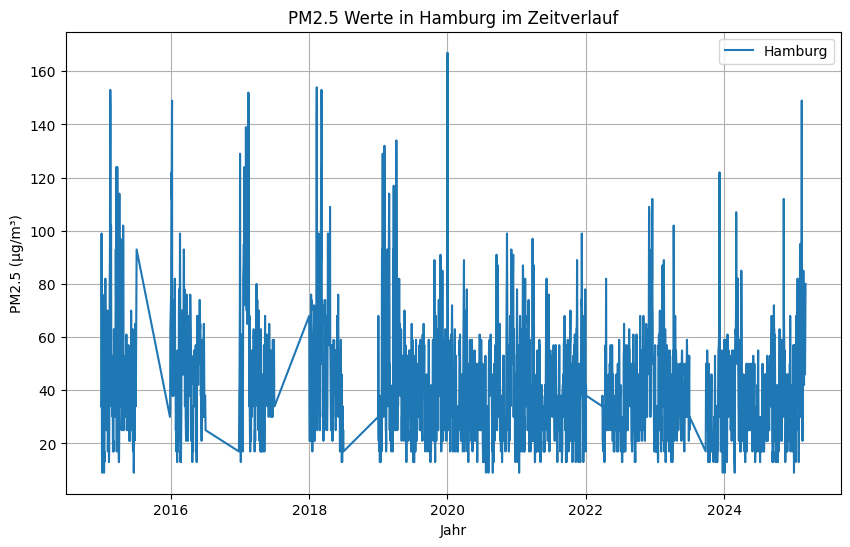

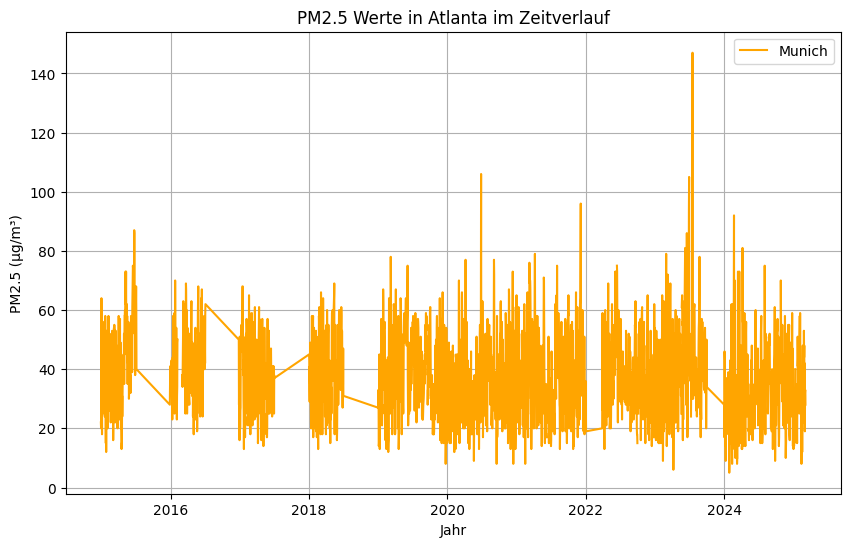

In [11]:
import matplotlib.pyplot as plt

# Plot der Zeitreihe für Hamburg
plt.figure(figsize=(10, 6))
plt.plot(df_hamburg.index, df_hamburg['Pm25'], label='Hamburg')
plt.title('PM2.5 Werte in Hamburg im Zeitverlauf')
plt.xlabel('Jahr')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.legend();

# Plot der Zeitreihe für Atlanta
plt.figure(figsize=(10, 6))
plt.plot(df_atlanta.index, df_atlanta['Pm25'], label='Munich', color='orange')
plt.title('PM2.5 Werte in Atlanta im Zeitverlauf')
plt.xlabel('Jahr')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.legend();


In [12]:
# Gleitender Durchschnitt (z. B. über 12 Monate)
df_hamburg['PM25_MA'] = df_hamburg['Pm25'].rolling(window=12).mean()
df_atlanta['PM25_MA'] = df_atlanta['Pm25'].rolling(window=12).mean()



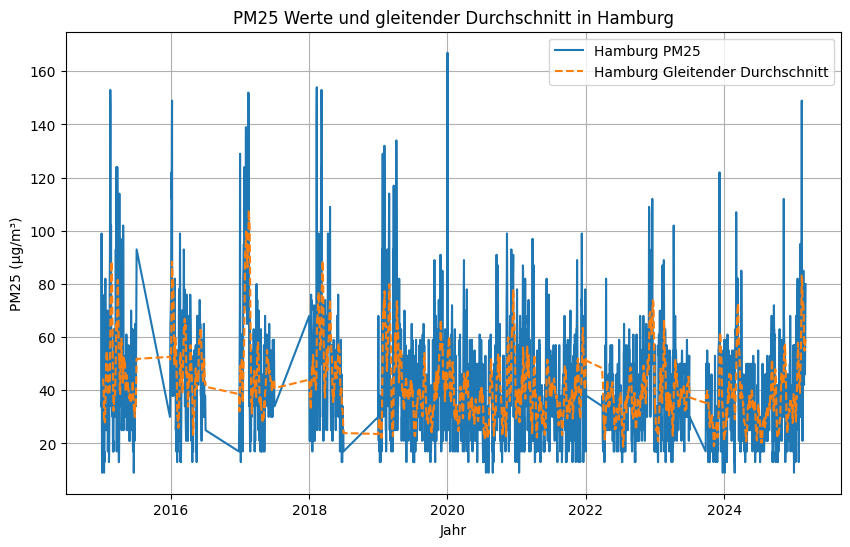

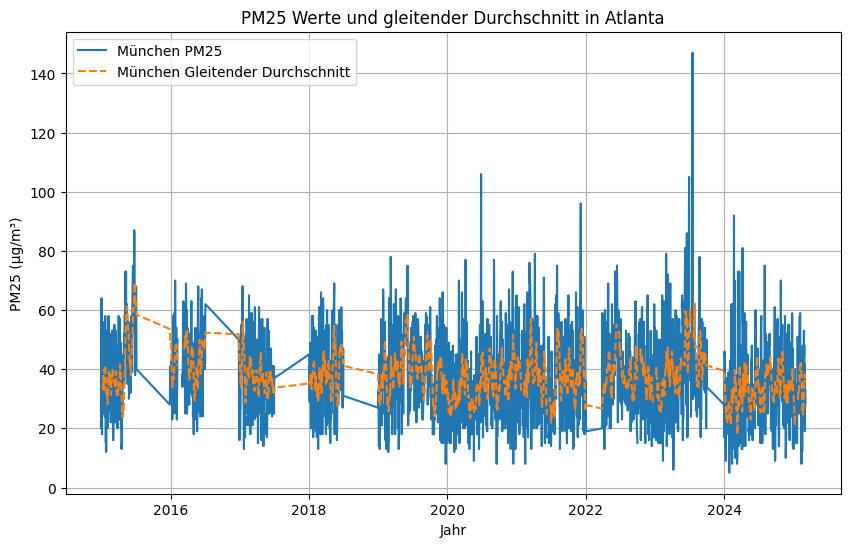

In [13]:
import matplotlib.dates as mdates


# Plot mit gleitendem Durchschnitt
plt.figure(figsize=(10, 6))
plt.plot(df_hamburg.index, df_hamburg['Pm25'], label='Hamburg PM25')
plt.plot(df_hamburg.index, df_hamburg['PM25_MA'], label='Hamburg Gleitender Durchschnitt', linestyle='--')
plt.title('PM25 Werte und gleitender Durchschnitt in Hamburg')
plt.xlabel('Jahr')
plt.ylabel('PM25 (µg/m³)')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(df_atlanta.index, df_atlanta['Pm25'], label='München PM25')
plt.plot(df_atlanta.index, df_atlanta['PM25_MA'], label='München Gleitender Durchschnitt', linestyle='--')
plt.title('PM25 Werte und gleitender Durchschnitt in Atlanta')
plt.xlabel('Jahr')
plt.ylabel('PM25 (µg/m³)')
plt.legend()
plt.grid(True)

Insgesamt beide Städte ähnluch, kaum Veränderungen über die Zeit.

Nächste Zoom-Stufe: Saisonale Schwankungen

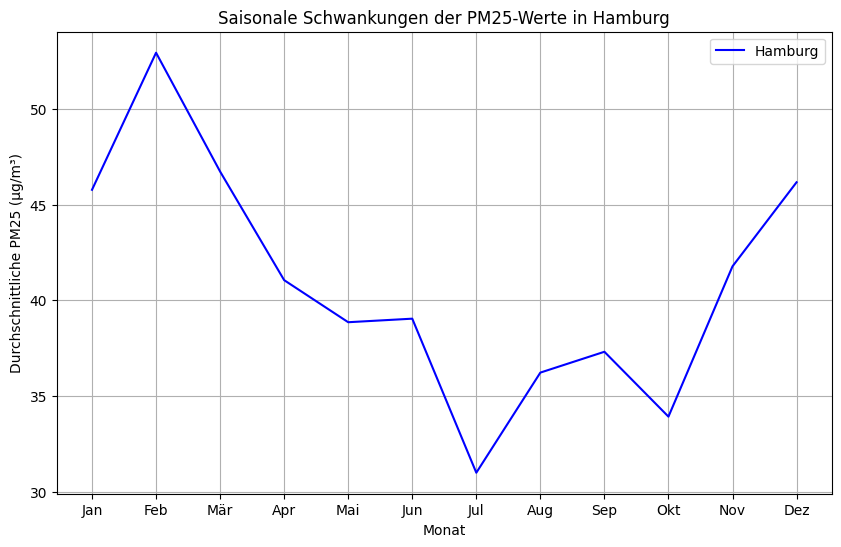

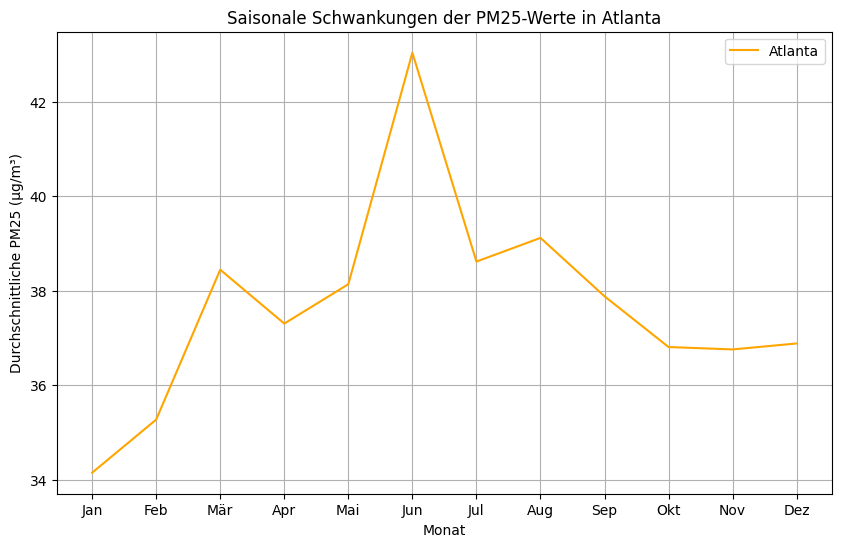

In [14]:
# Gruppiere die Daten nach Monat (oder Quartal) und berechne den Durchschnitt
df_hamburg_monthly = df_hamburg.groupby(df_hamburg.index.month)['Pm25'].mean()
df_atlanta_monthly = df_atlanta.groupby(df_atlanta.index.month)['Pm25'].mean()

# Plot für saisonale Schwankungen
plt.figure(figsize=(10, 6))
plt.plot(df_hamburg_monthly.index, df_hamburg_monthly, label='Hamburg', color='blue')
plt.title('Saisonale Schwankungen der PM25-Werte in Hamburg')
plt.xlabel('Monat')
plt.ylabel('Durchschnittliche PM25 (µg/m³)')
plt.grid(True)
plt.legend()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']);

plt.figure(figsize=(10, 6))
plt.plot(df_atlanta_monthly.index, df_atlanta_monthly, label='Atlanta', color='orange')
plt.title('Saisonale Schwankungen der PM25-Werte in Atlanta')
plt.xlabel('Monat')
plt.ylabel('Durchschnittliche PM25 (µg/m³)')
plt.grid(True)
plt.legend()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez']);


Hamburg und Atlanta zeigenn gegenläufige saisonale Muster. Mögliche Begründung:

- In Hamburg könnte die kühlere Luft und die stärkere Regen- und Windaktivität im Sommer für niedrigere PM2.5-Werte sorgen.

- In Atlanta könnte das heiße, feuchte Klima im Sommer zusammen mit weniger Luftzirkulation und mehr Verkehr und Industrieaktivitäten die PM2.5-Werte ansteigen lassen.

--> Kann man später z.B. mit den vorhandenen Wetterdaten und den übrigen Emissionswerten überprüfen.

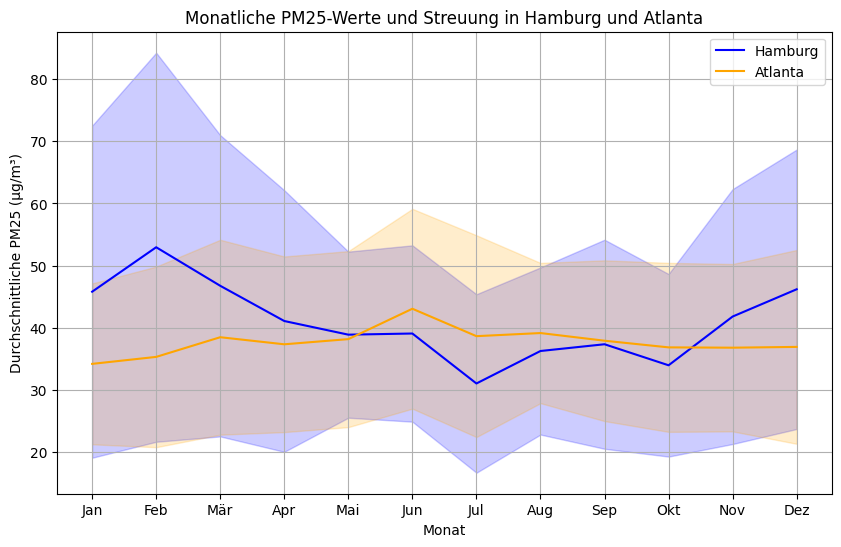

In [22]:
# Berechnung des monatlichen Mittelwerts und der Standardabweichung
df_hamburg_monthly = df_hamburg.groupby(df_hamburg.index.month)['Pm25'].agg(['mean', 'std'])
df_atlanta_monthly = df_atlanta.groupby(df_atlanta.index.month)['Pm25'].agg(['mean', 'std'])

# Plot der monatlichen Mittelwerte und der Standardabweichung als Fläche
plt.figure(figsize=(10, 6))

# Hamburg
plt.plot(df_hamburg_monthly.index, df_hamburg_monthly['mean'], label='Hamburg', color='blue')
plt.fill_between(df_hamburg_monthly.index, 
                 df_hamburg_monthly['mean'] - df_hamburg_monthly['std'], 
                 df_hamburg_monthly['mean'] + df_hamburg_monthly['std'], 
                 color='blue', alpha=0.2)

# Atlanta
plt.plot(df_atlanta_monthly.index, df_atlanta_monthly['mean'], label='Atlanta', color='orange')
plt.fill_between(df_atlanta_monthly.index, 
                 df_atlanta_monthly['mean'] - df_atlanta_monthly['std'], 
                 df_atlanta_monthly['mean'] + df_atlanta_monthly['std'], 
                 color='orange', alpha=0.2)

# Formatierung und Beschriftungen
plt.title('Monatliche PM25-Werte und Streuung in Hamburg und Atlanta')
plt.xlabel('Monat')
plt.ylabel('Durchschnittliche PM25 (µg/m³)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'])
plt.legend()
plt.grid(True);


Wenn man die Streuung einbezieht, überlappen sich die Graphen schon ziemlich. Fragt isch also, wie aussagekräftig der reine Durchschnitt über die Jahre hinweg ist. Da bleibt also noch viel zu analysieren.

Streuung nochmal berechnet, diesmal mit IQR

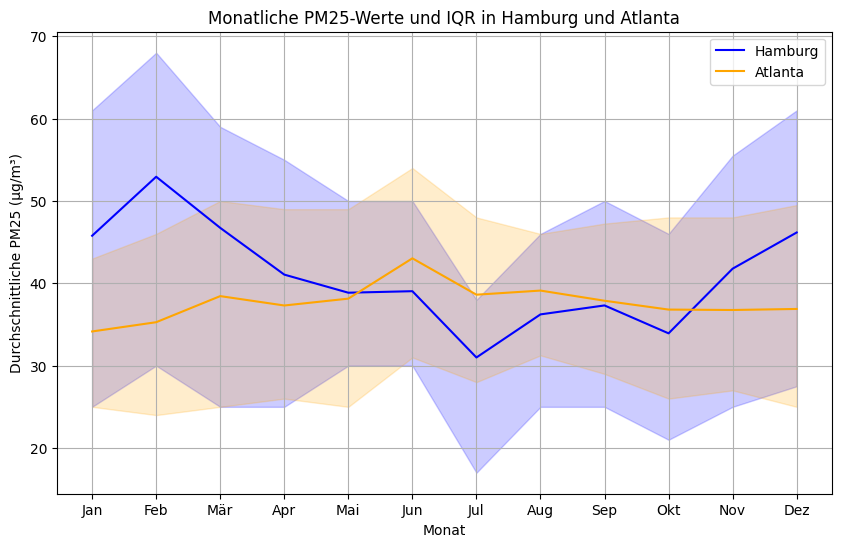

In [23]:
# Berechnung des monatlichen Mittelwerts und des Interquartilbereichs (IQR)
df_hamburg_monthly_iqr = df_hamburg.groupby(df_hamburg.index.month)['Pm25'].agg(lambda x: x.quantile(0.75) - x.quantile(0.25))
df_atlanta_monthly_iqr = df_atlanta.groupby(df_atlanta.index.month)['Pm25'].agg(lambda x: x.quantile(0.75) - x.quantile(0.25))

# Berechnung des 25. und 75. Perzentils
df_hamburg_monthly = df_hamburg.groupby(df_hamburg.index.month)['Pm25'].agg(['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
df_atlanta_monthly = df_atlanta.groupby(df_atlanta.index.month)['Pm25'].agg(['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])

# Plot der monatlichen Mittelwerte und IQR als Fläche
plt.figure(figsize=(10, 6))

# Hamburg
plt.plot(df_hamburg_monthly.index, df_hamburg_monthly['mean'], label='Hamburg', color='blue')
plt.fill_between(df_hamburg_monthly.index, 
                 df_hamburg_monthly['<lambda_0>'], 
                 df_hamburg_monthly['<lambda_1>'], 
                 color='blue', alpha=0.2)

# Atlanta
plt.plot(df_atlanta_monthly.index, df_atlanta_monthly['mean'], label='Atlanta', color='orange')
plt.fill_between(df_atlanta_monthly.index, 
                 df_atlanta_monthly['<lambda_0>'], 
                 df_atlanta_monthly['<lambda_1>'], 
                 color='orange', alpha=0.2)

# Formatierung und Beschriftungen
plt.title('Monatliche PM25-Werte und IQR in Hamburg und Atlanta')
plt.xlabel('Monat')
plt.ylabel('Durchschnittliche PM25 (µg/m³)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'])
plt.legend()
plt.grid(True);


Darstellung mit IQR klarer als mit Mean, weil umempfindlicher gegenüber Ausreißern.

In [26]:
# Bestimmung von Ausreißern basierend auf dem interquartilen Bereich (IQR)
Q1_hamburg = df_hamburg['Pm25'].quantile(0.25)
Q3_hamburg = df_hamburg['Pm25'].quantile(0.75)
IQR_hamburg = Q3_hamburg - Q1_hamburg
outliers_hamburg = df_hamburg[(df_hamburg['Pm25'] < (Q1_hamburg - 1.5 * IQR_hamburg)) | (df_hamburg['Pm25'] > (Q3_hamburg + 1.5 * IQR_hamburg))]

Q1_atlanta = df_atlanta['Pm25'].quantile(0.25)
Q3_atlanta = df_atlanta['Pm25'].quantile(0.75)
IQR_atlanta = Q3_atlanta - Q1_atlanta
outliers_atlanta = df_atlanta[(df_atlanta['Pm25'] < (Q1_atlanta - 1.5 * IQR_atlanta)) | (df_atlanta['Pm25'] > (Q3_atlanta + 1.5 * IQR_atlanta))]

# Ausreißer anzeigen
print("Ausreißer in Hamburg:\n", len(outliers_hamburg), outliers_hamburg[['Pm25']])
print("Ausreißer in Atlanta:\n", len(outliers_atlanta), outliers_atlanta[['Pm25']])


Ausreißer in Hamburg:
 48              Pm25
Date             
2015-02-15  124.0
2015-02-16  153.0
2015-02-17  147.0
2015-02-20  102.0
2015-03-20  124.0
2015-03-24  107.0
2015-03-25  124.0
2015-03-26  112.0
2015-04-05  114.0
2015-04-25  102.0
2016-01-04  102.0
2016-01-05  122.0
2016-01-06  112.0
2016-01-07  139.0
2016-01-08  149.0
2017-01-01  129.0
2017-01-24  124.0
2017-01-25  114.0
2017-02-01  139.0
2017-02-10  114.0
2017-02-11  137.0
2017-02-13  132.0
2017-02-14  152.0
2017-02-15  144.0
2017-02-16  151.0
2018-02-09  142.0
2018-02-10  154.0
2018-03-05  124.0
2018-03-07  153.0
2018-03-08  139.0
2018-04-21  109.0
2019-01-24  129.0
2019-02-02  132.0
2019-02-03  114.0
2019-02-26  107.0
2019-02-27  114.0
2019-03-23  117.0
2019-04-06  134.0
2019-04-07  112.0
2020-01-01  167.0
2022-11-30  109.0
2022-12-01  107.0
2022-12-17  112.0
2023-04-09  102.0
2023-12-07  122.0
2024-03-04  107.0
2024-11-10  112.0
2025-02-13  149.0
Ausreißer in Atlanta:
 13              Pm25
Date             
2015-06-23  

In [20]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Erstelle ein Jahr-Array als unabhängige Variable
years_hamburg = np.array(df_hamburg.index.year).reshape(-1, 1)
years_atlanta = np.array(df_atlanta.index.year).reshape(-1, 1)

# Führe die Regression für Hamburg durch
reg_hamburg = LinearRegression().fit(years_hamburg, df_hamburg['Pm25'])
slope_hamburg = reg_hamburg.coef_[0]
intercept_hamburg = reg_hamburg.intercept_

# Führe die Regression für Atlanta durch
reg_atlanta = LinearRegression().fit(years_atlanta, df_atlanta['Pm25'])
slope_atlanta = reg_atlanta.coef_[0]
intercept_atlanta = reg_atlanta.intercept_

print(f"Trend in Hamburg (Steigung): {slope_hamburg}")
print(f"Trend in Atlanta (Steigung): {slope_atlanta}")


ValueError: Input y contains NaN.